# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
!pip install wget
!pip install zipfile36

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=487a3dea6bf585d9774bfc8003b95740f7228a45176f185d873f622e9f1b03cd
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget
import zipfile
dir_path = 'content/'
filename=wget.download('https://ndownloader.figshare.com/files/21001311')
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("")
!rm fashion_mnist.zip
wget.download('https://raw.githubusercontent.com/automl/LCBench/master/api.py')
wget.download('https://raw.githubusercontent.com/infomon/Extrapolation-of-Learning-Curves/master/utils.py')
!mkdir content/models
!mkdir models

mkdir: cannot create directory ‘content/models’: No such file or directory


In [0]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from content.api import Benchmark
import content.utils as utils
import torch

In [4]:
bench_dir = dir_path+"fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [41]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    #val_data, val_targets = cut_data(val_data, cut_position)
    #test_data, test_targets = cut_data(test_data, cut_position)
    val_data, val_targets = cut_data(val_data, 51)
    test_data, test_targets = cut_data(test_data, 51)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [6]:
# Config
print("Config example:", train_data[0]["config"])

Config example: {'batch_size': 71, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.025926231827891333, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 293, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.0018243300267253295, 'momentum': 0.21325193168301043, 'weight_decay': 0.020472816917443872}


In [7]:
train_data[1]["config"]

{'activation': 'relu',
 'batch_size': 457,
 'cosine_annealing_T_max': 50,
 'cosine_annealing_eta_min': 1e-08,
 'imputation_strategy': 'mean',
 'learning_rate': 0.01239328605026128,
 'learning_rate_scheduler': 'cosine_annealing',
 'loss': 'cross_entropy_weighted',
 'max_dropout': 0.5472322491757223,
 'max_units': 950,
 'mlp_shape': 'funnel',
 'momentum': 0.16411425552061212,
 'network': 'shapedmlpnet',
 'normalization_strategy': 'standardize',
 'num_layers': 4,
 'optimizer': 'sgd',
 'weight_decay': 0.09762768273307641}

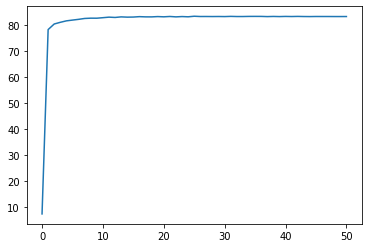

In [8]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

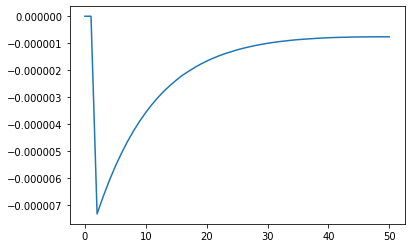

In [9]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

## A simple baseline

In [0]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [11]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

Score on validation set: 31.921338670622784


In [12]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)

Final test score: 24.199496266785523


In [0]:
train_data_loader = utils.prep_data(train_data, train_targets, batch_size=32,normalization_factor_temporal_data=[100], one_shot=True)
val_data_loader = utils.prep_data(val_data, val_targets, batch_size=32,normalization_factor_temporal_data=[100], one_shot=True)
test_data_loader = utils.prep_data(test_data, test_targets, batch_size=32,normalization_factor_temporal_data=[100],one_shot=True)

In [0]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, nof_configs, num_layers, dropout = 0.5, bidirectional=False):
        super(EncoderRNN, self).__init__()
        
        self.nof_configs = nof_configs
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size=input_size, 
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  dropout=dropout,
                                  bidirectional=bidirectional)

        self.relu = torch.nn.functional.relu

        self.encode_fc1 = torch.nn.Linear(self.nof_configs,int(self.hidden_size/2))
        self.encode_bn1 = torch.nn.BatchNorm1d(int(self.hidden_size/2))
        self.encode_fc2 = torch.nn.Linear(int(self.hidden_size/2),self.hidden_size)
        self.encode_bn2 = torch.nn.BatchNorm1d(self.hidden_size)

    def forward(self, seq, config):
        h0 = self.initHidden(config)
        c0 = self.initCell(seq.size()[0])
        seq = torch.t(seq)
        seq = seq.unsqueeze(-1)
        output, (hidden,cell) = self.lstm(seq, (h0,c0))
        return output, hidden, cell

    def initHidden(self, config):
        x = self.relu(self.encode_bn1(self.encode_fc1(config)))
        x = self.relu(self.encode_bn2(self.encode_fc2(x)))
        return torch.stack([x for _ in range(self.num_layers*self.num_directions)])

    def initCell(self, batch_size):
        return torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_size)

In [0]:
class DecoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout = 0.5, bidirectional=False):
        super(DecoderRNN, self).__init__()
        
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size=input_size, 
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  dropout=dropout,
                                  bidirectional=bidirectional)
        
        self.fc_out = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.functional.relu

    def forward(self, seq, h0, c0):
        seq = seq.unsqueeze(0)
        seq = seq.unsqueeze(-1)
        output, (hidden,cell) = self.lstm(seq, (h0,c0))
        output = self.fc_out(output)
        return output.squeeze(), hidden, cell


In [0]:
class Seq2Seq(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

    assert encoder.hidden_size == decoder.hidden_size
    assert encoder.num_layers == decoder.num_layers

  def forward(self, source, target, teacher_forcing_ratio = 0.5):
    batch_size = target.size()[0]
    target_len = target.size()[1]

    outputs = torch.zeros(target_len, batch_size, 1)

    seq , config = source
    output, hidden, cell = self.encoder(seq, config)

    decoder_input = target[:,0]
    for t in range(1, target_len):
      output, hidden, cell = self.decoder(decoder_input, hidden, cell)
      outputs[t] = output.unsqueeze(-1)
      use_teacher_forcing = np.random.random() < teacher_forcing_ratio
      decoder_input = target[:,t] if use_teacher_forcing else output
    return outputs

In [0]:
def init_weights(m):
  for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)

In [0]:
input_size = 1
outcome_dim = 1
hidden_dim = 32
num_layers = 2
config_size = 7
lr=0.01
epochs=100

encoder = EncoderRNN(input_size, hidden_dim, config_size, num_layers)
decoder = DecoderRNN(input_size, hidden_dim, outcome_dim, num_layers)
model = Seq2Seq(encoder, decoder)
model.apply(init_weights)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-3)

In [0]:
def train(model, optimizer, criterion, clip=5):
    model.train()
    epoch_loss = 0
    for val_acc, configs, targets in train_data_loader:
      optimizer.zero_grad()
      output = model([val_acc,configs],targets)
      output = output.squeeze()
      output = torch.t(output)
      loss = criterion(output, targets)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(),clip)
      optimizer.step()
      epoch_loss += loss.item()
    return epoch_loss/len(train_data_loader)

In [0]:
def evaluate(model, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for val_acc, configs, targets in val_data_loader:
      output = model([val_acc, configs], targets, 0)
      output = output.squeeze()
      output = torch.t(output)
      loss = criterion(output, targets)
      epoch_loss += loss.item()
  return epoch_loss / len(val_data_loader)

In [47]:
best_val_loss = float('inf')

for epoch in range(epochs):
  train_loss = train(model, optimizer, criterion)
  val_loss = evaluate(model, criterion)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(),"content/models/model.pt")    
    print('Val loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_val_loss,val_loss))
    best_val_loss = val_loss

  print(f'Epoch: {epoch}\t Train Loss: {train_loss:.3f}\t Val. Loss: {val_loss:.3f}')

Val loss decreased (inf --> 11.429819).  Saving model ...
Epoch: 0	 Train Loss: 13.472	 Val. Loss: 11.430
Epoch: 1	 Train Loss: 14.497	 Val. Loss: 11.471
Epoch: 2	 Train Loss: 13.632	 Val. Loss: 16.561
Epoch: 3	 Train Loss: 16.085	 Val. Loss: 11.483
Epoch: 4	 Train Loss: 20.310	 Val. Loss: 18.983
Epoch: 5	 Train Loss: 16.507	 Val. Loss: 14.132
Epoch: 6	 Train Loss: 15.700	 Val. Loss: 25.996
Epoch: 7	 Train Loss: 19.416	 Val. Loss: 13.997
Epoch: 8	 Train Loss: 16.500	 Val. Loss: 17.395
Epoch: 9	 Train Loss: 13.345	 Val. Loss: 16.767
Epoch: 10	 Train Loss: 15.476	 Val. Loss: 12.779
Epoch: 11	 Train Loss: 13.931	 Val. Loss: 13.053
Epoch: 12	 Train Loss: 15.421	 Val. Loss: 12.090
Epoch: 13	 Train Loss: 13.875	 Val. Loss: 12.831
Epoch: 14	 Train Loss: 17.069	 Val. Loss: 12.656
Epoch: 15	 Train Loss: 16.820	 Val. Loss: 13.463
Epoch: 16	 Train Loss: 15.513	 Val. Loss: 13.287
Epoch: 17	 Train Loss: 15.645	 Val. Loss: 15.562
Epoch: 18	 Train Loss: 22.758	 Val. Loss: 20.379
Epoch: 19	 Train Loss

In [0]:
def test(model, criterion):
    model.load_state_dict(torch.load('content/models/model.pt'))
    model.eval()
    test_losses = []
    with torch.no_grad():
      for val_acc, configs, targets in test_data_loader:
        output = model([val_acc, configs], targets, 0)
        output = output.squeeze()
        output = torch.t(output)
        loss = criterion(output[:,-1], targets[:,-1])
        test_losses.append(loss.item())

    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    return np.mean(test_losses)

In [49]:
test_acc = test(model, criterion)

Test loss: 7.855


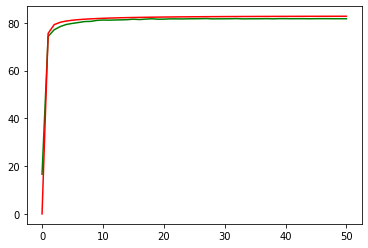

In [52]:
import matplotlib.pyplot as plt
def plot_curve(model):
  model.load_state_dict(torch.load('content/models/model.pt'))
  model.eval()
  with torch.no_grad():
      for val_acc, configs, targets in test_data_loader:
        output = model([val_acc, configs], targets, 0)
        output = output.squeeze()
        output = torch.t(output)
        plt.plot(np.arange(51),targets[31],c='g')
        plt.plot(np.arange(51),output[31],c='r')
        plt.show()
        break

plot_curve(model)